# Geodesic Calculus on MNIST Latent Space

## Introduction

This notebook explores geodesic interpolation on learned manifolds, inspired by the recent work on **Geodesic Calculus on Latent Space, [Hartwig et al. 2025](https://arxiv.org/pdf/2510.09468)**. The goal is to visualize how a neural network can learn a **projection operator $\Pi$** that constrains movements in the latent space of a trained **Variational Autoencoder (VAE)**, such that interpolations follow the *intrinsic geometry* of the data manifold.

We first train a VAE on the **MNIST dataset**, which learns a latent representation of handwritten digits.
Then, we train a **projection network Π** to map any point in latent space back onto the manifold of valid encodings, by enforcing:
- **Denoising property:** $\Pi(z + \text{noise}) \approx z$

Once $\Pi$ is learned, we can compute **geodesic paths** between latent codes, that is, smooth curves that remain on the manifold and minimize energy (path length). This allows us to generate more realistic and semantically consistent transitions between two digits (e.g., “1 → 8”), compared to simple **linear interpolation** in latent space.

Finally, we visualize:

- The **geodesic vs. linear interpolations** (decoded as digit images)
- The **latent manifold** using 2D PCA projections, where both trajectories can be observed

This experiment demonstrates how learning a projection $\Pi$ can improve the geometric coherence of interpolations in latent space, providing a first step toward **geometry-aware generative models**.

## Training VAE on MNIST

In this section, we train a **Variational Autoencoder (VAE)** to learn a compact, continuous latent representation of handwritten digits from the MNIST dataset. The encoder maps 28x28 grayscale images into a 16 dimensional latent space, while the decoder reconstructs images from latent codes. The VAE is trained by minimizing a combination of:

- **Reconstruction loss** (mean squared error): ensures decoded images resemble the originals.
- **Kullback–Leibler (KL) divergence**: regularizes the latent distribution toward a unit Gaussian, encouraging smoothness and disentanglement.

This training process yields a latent manifold where digits of similar appearance are embedded nearby.
Such a smooth, structured latent space is crucial for downstream geometric operations, particularly the learning of a projection operator $\Pi$, which will later constrain geodesic interpolation to stay on the manifold of valid latent representations.

After 15 epochs, we monitor convergence through:

- Total VAE loss
- Reconstruction and KL components on both training and validation sets.

A well-trained VAE produces coherent reconstructions and provides a stable latent space for learning manifold geometry in the next phase.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.2 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

100%|██████████| 9.91M/9.91M [00:00<00:00, 30.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.03MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.67MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.78MB/s]


[VAE] epoch 01 | train 164.410 (rec 154.16, kl 10.25) | val 112.366
[VAE] epoch 02 | train 100.387 (rec 83.09, kl 17.30) | val 91.520
[VAE] epoch 03 | train 87.286 (rec 68.15, kl 19.13) | val 82.604
[VAE] epoch 04 | train 80.965 (rec 60.82, kl 20.14) | val 77.852
[VAE] epoch 05 | train 77.509 (rec 56.86, kl 20.65) | val 75.894
[VAE] epoch 06 | train 75.145 (rec 54.22, kl 20.92) | val 73.166
[VAE] epoch 07 | train 73.379 (rec 52.21, kl 21.17) | val 72.741
[VAE] epoch 08 | train 72.108 (rec 50.71, kl 21.40) | val 71.256
[VAE] epoch 09 | train 71.027 (rec 49.52, kl 21.50) | val 70.942
[VAE] epoch 10 | train 70.081 (rec 48.47, kl 21.61) | val 69.307
[VAE] epoch 11 | train 69.235 (rec 47.55, kl 21.69) | val 69.298
[VAE] epoch 12 | train 68.622 (rec 46.87, kl 21.75) | val 68.460
[VAE] epoch 13 | train 68.077 (rec 46.25, kl 21.83) | val 67.525
[VAE] epoch 14 | train 67.408 (rec 45.49, kl 21.91) | val 67.095
[VAE] epoch 15 | train 66.934 (rec 45.00, kl 21.93) | val 67.330


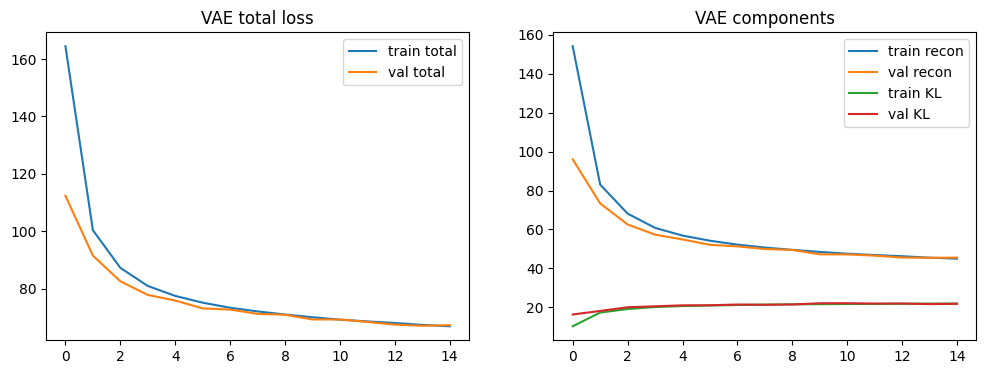

In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ============================================================
# Dataset
# ============================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_set, val_set = random_split(mnist, [55000, 5000])
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128)

# ============================================================
# Variational Autoencoder
# ============================================================
class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400), nn.ReLU(),
            nn.Linear(400, 200), nn.ReLU()
        )
        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logvar = nn.Linear(200, latent_dim)
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 200), nn.ReLU(),
            nn.Linear(200, 400), nn.ReLU(),
            nn.Linear(400, 28*28), nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        out = self.decoder(z)
        return out.view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

# ============================================================
# VAE Training
# ============================================================
vae = VAE(latent_dim=16).to(DEVICE)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

def loss_vae(x, x_hat, mu, logvar):
    recon = F.mse_loss(x_hat, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon + kl) / x.size(0), recon / x.size(0), kl / x.size(0)

EPOCHS_VAE = 15
logs = {"train_total":[], "train_rec":[], "train_kl":[],
        "val_total":[], "val_rec":[], "val_kl":[]}

for ep in range(1, EPOCHS_VAE+1):
    vae.train()
    t_loss = r_loss = k_loss = 0
    for x,_ in train_loader:
        x = x.to(DEVICE)
        x_hat, mu, logvar = vae(x)
        loss, rec, kl = loss_vae(x, x_hat, mu, logvar)
        opt.zero_grad(); loss.backward(); opt.step()
        t_loss += loss.item(); r_loss += rec.item(); k_loss += kl.item()
    n = len(train_loader)
    logs["train_total"].append(t_loss/n)
    logs["train_rec"].append(r_loss/n)
    logs["train_kl"].append(k_loss/n)

    vae.eval(); t_loss = r_loss = k_loss = 0
    with torch.no_grad():
        for x,_ in val_loader:
            x = x.to(DEVICE)
            x_hat, mu, logvar = vae(x)
            loss, rec, kl = loss_vae(x, x_hat, mu, logvar)
            t_loss += loss.item(); r_loss += rec.item(); k_loss += kl.item()
    n = len(val_loader)
    logs["val_total"].append(t_loss/n)
    logs["val_rec"].append(r_loss/n)
    logs["val_kl"].append(k_loss/n)

    print(f"[VAE] epoch {ep:02d} | train {logs['train_total'][-1]:.3f} (rec {logs['train_rec'][-1]:.2f}, kl {logs['train_kl'][-1]:.2f}) | val {logs['val_total'][-1]:.3f}")

# ============================================================
# Plot VAE losses
# ============================================================
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(logs["train_total"], label="train total")
ax[0].plot(logs["val_total"], label="val total")
ax[0].set_title("VAE total loss"); ax[0].legend()
ax[1].plot(logs["train_rec"], label="train recon")
ax[1].plot(logs["val_rec"], label="val recon")
ax[1].plot(logs["train_kl"], label="train KL")
ax[1].plot(logs["val_kl"], label="val KL")
ax[1].set_title("VAE components"); ax[1].legend()
plt.show()


## Learning the Projection $\Pi$

Once the VAE has learned a meaningful latent space, we train a **projection network $\Pi$** that maps arbitrary points in the latent space back onto the manifold of valid encodings. This projection acts as a **denoising operator**: given a perturbed latent vector $ z + \varepsilon $, the network learns to recover the closest valid latent point $ \Pi(z + \varepsilon) \approx z $.

The training objective is a simple mean squared error (MSE) loss between the projected latent codes and their clean counterparts, using Gaussian perturbations of the form

$$
\mathcal{L} = || \Pi(z + \varepsilon) - z ||^2
$$

where $z$ are encoder outputs from the frozen VAE and $ \varepsilon \sim \mathcal{N}(0, \sigma^2 I) $.

By minimizing this loss, $\Pi$ gradually learns the local geometry of the latent manifold.
It becomes **contractive** (bringing noisy points closer to the manifold) and **idempotent** (reapplying $\Pi$ doesn’t change already-clean points). This makes it a differentiable approximation of a *Riemannian projection*, enabling geodesic computations in the next step.

During training, we monitor the **train and validation reconstruction losses** to ensure $\Pi$ stabilizes around low reconstruction energy, indicating successful alignment with the VAE’s latent manifold.

[Π] epoch 01 | train 0.0723 | val 0.0661
[Π] epoch 02 | train 0.0653 | val 0.0641
[Π] epoch 03 | train 0.0646 | val 0.0642
[Π] epoch 04 | train 0.0638 | val 0.0637
[Π] epoch 05 | train 0.0635 | val 0.0636
[Π] epoch 06 | train 0.0632 | val 0.0632
[Π] epoch 07 | train 0.0629 | val 0.0630
[Π] epoch 08 | train 0.0627 | val 0.0626
[Π] epoch 09 | train 0.0621 | val 0.0620
[Π] epoch 10 | train 0.0621 | val 0.0618
[Π] epoch 11 | train 0.0620 | val 0.0614
[Π] epoch 12 | train 0.0617 | val 0.0613
[Π] epoch 13 | train 0.0613 | val 0.0616
[Π] epoch 14 | train 0.0613 | val 0.0604
[Π] epoch 15 | train 0.0611 | val 0.0606
[Π] epoch 16 | train 0.0610 | val 0.0611
[Π] epoch 17 | train 0.0608 | val 0.0612
[Π] epoch 18 | train 0.0609 | val 0.0607
[Π] epoch 19 | train 0.0605 | val 0.0605
[Π] epoch 20 | train 0.0606 | val 0.0603
[Π] epoch 21 | train 0.0603 | val 0.0599
[Π] epoch 22 | train 0.0602 | val 0.0604
[Π] epoch 23 | train 0.0602 | val 0.0601
[Π] epoch 24 | train 0.0601 | val 0.0602
[Π] epoch 25 | t

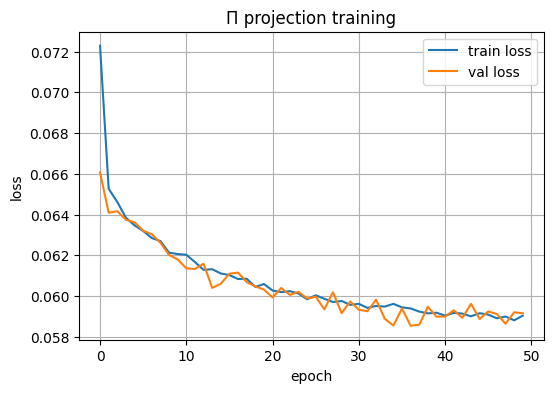

In [18]:
# ============================================================
# Projection Π Network
# ============================================================
class ProjectionNet(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, dim)
        )
    def forward(self, z):
        return z + 0.3 * self.net(z)

Pi = ProjectionNet(vae.latent_dim).to(DEVICE)

# ============================================================
# Π Training Loop
# ============================================================
def train_projection(Pi, vae, train_loader, val_loader, epochs=10, sigma=0.3, lr=1e-3):
    opt = torch.optim.Adam(Pi.parameters(), lr=lr)
    logs = {"train_loss": [], "val_loss": []}

    for ep in range(1, epochs+1):
        # ---- Train ----
        Pi.train(); vae.eval()
        total_train = 0; nb = 0
        for x, _ in train_loader:
            x = x.to(DEVICE)
            with torch.no_grad():
                mu, _ = vae.encode(x)
            z = mu
            z_noisy = z + sigma * torch.randn_like(z)
            z_hat = Pi(z_noisy)
            loss = F.mse_loss(z_hat, z)
            opt.zero_grad()
            loss.backward()
            opt.step()

            total_train += loss.item()
            nb += 1

        logs["train_loss"].append(total_train / nb)

        # ---- Validation ----
        Pi.eval(); total_val = 0; nb = 0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(DEVICE)
                mu, _ = vae.encode(x)
                z = mu
                z_noisy = z + sigma * torch.randn_like(z)
                z_hat = Pi(z_noisy)
                loss = F.mse_loss(z_hat, z)
                total_val += loss.item()
                nb += 1

        logs["val_loss"].append(total_val / nb)

        print(f"[Π] epoch {ep:02d} | train {logs['train_loss'][-1]:.4f} | val {logs['val_loss'][-1]:.4f}")

    # ---- Plot ----
    plt.figure(figsize=(6, 4))
    plt.plot(logs["train_loss"], label="train loss")
    plt.plot(logs["val_loss"], label="val loss")
    plt.title("Π projection training")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.savefig("pi-projection-training.png")
    plt.show()

    return logs

logs_pi = train_projection(Pi, vae, train_loader, val_loader, epochs=50, sigma=0.3)

## Geodesic Interpolation in the Latent Manifold

The purpose of this section is to compute **geodesic paths** between two latent points, for instance, between digits *“1”* and *“8”*, while ensuring that the interpolation remains close to the learned latent manifold of the VAE.

A standard latent space interpolation is performed linearly between encodings $z_a$ and $z_b$:

$$
\gamma_{\text{linear}}(t) = (1-t)z_a + tz_b
$$

However, this linear interpolation often cuts through regions of the latent space where the decoder has not learned meaningful structure. This results in unrealistic or blurry intermediate samples.

To address this, instead of following a straight line, we iteratively optimize a discrete curve $ \gamma = (\gamma_0, \ldots, \gamma_K) $ to minimize its **geodesic energy functional**:

$$
E(\gamma) = \sum_{k=0}^{K-1} |\gamma_{k+1} - \gamma_k|^2 + \lambda |\gamma|^2
$$

subject to the constraint that each intermediate point stays close to the manifold via the projection $\Pi$:

$$
\gamma_{1:K-1} \leftarrow \Pi(\gamma_{1:K-1})
$$

The optimization seeks a balance between **path smoothness** (shorter distances between consecutive points) and **manifold consistency** (projection regularization). In practice, the energy may increase slightly before stabilizing, which reflects the fact that the projected geodesic is *longer* than the straight line, it bends to remain inside the manifold learned by the VAE. It means the geodesic is *respecting the topology* of the latent space, rather than taking an unrealistic shortcut through low-density regions. The resulting path produces **smoother and more semantically meaningful transitions** in decoded space, as shown below.

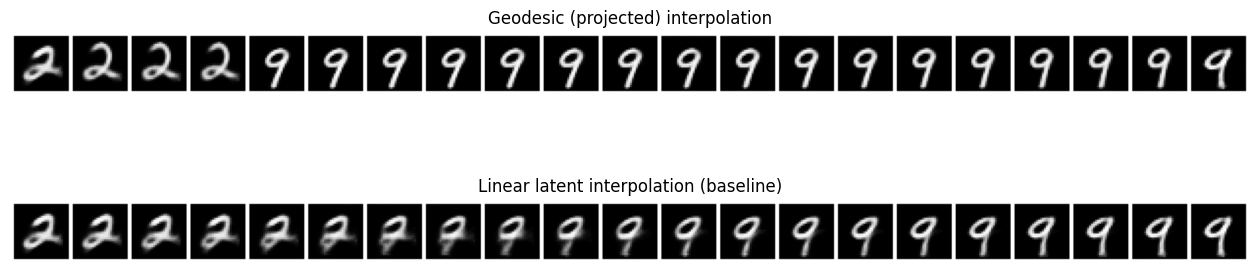

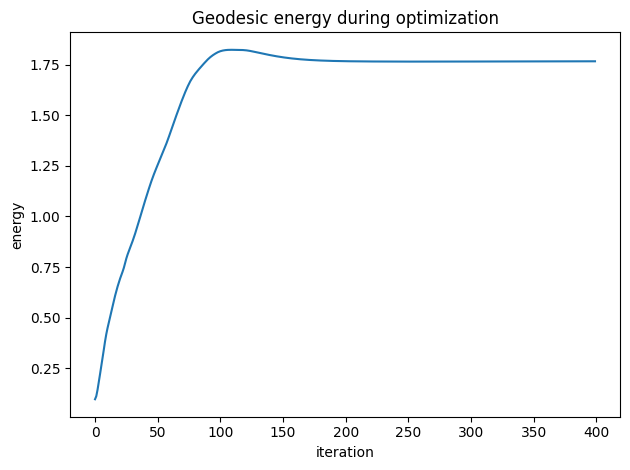

In [47]:
import torch
import torch.nn.functional as F

def geodesic_between(Pi, z_a, z_b, K=20, iters=400, lr=5e-3, reg=0.1):
    """
    Learn a geodesic curve γ between z_a and z_b under projection Π.
    Returns:
        γ_opt (Tensor): optimized path (K+1, latent_dim)
        energy_curve (list): energy values across iterations
        smoothness_curve (list): average step variance
    """
    # --- Initialize linear path
    gamma = torch.stack([
        z_a + (t / K) * (z_b - z_a) for t in range(K + 1)
    ], dim=0).detach().clone().requires_grad_(True)

    opt = torch.optim.Adam([gamma], lr=lr)
    energy_curve = []

    for i in range(iters):
        with torch.no_grad():
            gamma.data[0] = z_a
            gamma.data[-1] = z_b

        # --- Compute discrete energy functional
        diffs = gamma[1:] - gamma[:-1]
        E = (diffs.pow(2).sum(1)).mean()  # average squared step length
        reg_term = reg * gamma.pow(2).mean()
        loss = E + reg_term

        # --- Optimization step (minimize energy)
        opt.zero_grad()
        loss.backward()
        opt.step()

        # --- Project intermediate points back on manifold
        with torch.no_grad():
            gamma[1:-1] = Pi(gamma[1:-1])

        # --- Compute diagnostics
        step_norms = diffs.norm(dim=1)
        energy_curve.append(loss.item())

    return gamma.detach(), energy_curve

# Find indices for specific digits
idx_start = next(i for i, (_, y) in enumerate(mnist) if y == 2)
idx_end = next(i for i, (_, y) in enumerate(mnist) if y == 9)

# Load those two digits
img1 = mnist[idx_start][0].unsqueeze(0).to(DEVICE)
img8 = mnist[idx_end][0].unsqueeze(0).to(DEVICE)
imgs = [img1, img8]

# Encode those digits in the latent space
vae.eval()
mu1, _ = vae.encode(imgs[0])
mu2, _ = vae.encode(imgs[1])
z_a, z_b = mu1[0], mu2[0]

geo_path, energy = geodesic_between(Pi, z_a, z_b)
lin_path = torch.stack([z_a + (t/len(geo_path))*(z_b - z_a) for t in range(len(geo_path))])

with torch.no_grad():
    recon_geo = vae.decode(geo_path).cpu()
    recon_lin = vae.decode(lin_path).cpu()

# ============================================================
# Visualizations
# ============================================================
grid_geo = utils.make_grid(recon_geo, nrow=len(geo_path), normalize=True, pad_value=1)
grid_lin = utils.make_grid(recon_lin, nrow=len(lin_path), normalize=True, pad_value=1)

fig, ax = plt.subplots(2,1,figsize=(16,4))
ax[0].imshow(grid_geo.permute(1,2,0).squeeze(), cmap="gray")
ax[0].set_title("Geodesic (projected) interpolation")
ax[0].axis("off")
ax[1].imshow(grid_lin.permute(1,2,0).squeeze(), cmap="gray")
ax[1].set_title("Linear latent interpolation (baseline)")
ax[1].axis("off")
plt.savefig("interpolations.png")
plt.show()

plt.plot(energy)
plt.title("Geodesic energy during optimization")
plt.xlabel("iteration")
plt.ylabel("energy")
plt.tight_layout()
plt.savefig("geodesic-energy.png")
plt.show()

- The energy rises at first because the projection pushes points away from the linear shortcut toward valid manifold regions.
- It then stabilizes, meaning the curve has reached an equilibrium where projection and smoothness forces balance each other.
- A stable, plateau-shaped energy curve thus indicates a **converged, manifold-consistent geodesic**.

### Comments on the interpolation results

The figure above compares two latent-space interpolations between two digits (“2” → “9”):

- **Linear interpolation (bottom)**: The path directly connects the two latent codes through a straight line. As a result, the intermediate points often pass through **low-density regions** of the latent space, areas that the VAE decoder has never seen during training. This produces blurry, unrealistic in-between digits where the model is unsure how to reconstruct valid shapes.

- **Geodesic (projected) interpolation (top)**: Each intermediate latent point is iteratively **projected back onto the manifold** learned by the VAE using $\Pi$. This constrains the interpolation to follow regions of high data density, where reconstructions remain valid. The transitions are smoother and visually more consistent, with all intermediate samples staying close to meaningful digit structures. Notice how the morph passes naturally from a “2” to a “9” through stable, well-formed digits, without the fuzzy blending seen in the linear baseline.

Overall, this confirms that the projection $\Pi$ successfully regularizes the latent space by enforcing smooth, contractive behavior around the data manifold. 


## PCA visualization of latent space and paths

In this final visualization step, the latent manifold learned by the VAE is projected into two dimensions using Principal Component Analysis (PCA) to make its structure interpretable. A set of latent codes is extracted from the validation set and plotted as a cloud of points colored by their corresponding digit labels, revealing the organization of different classes in the latent space.

The **linear interpolation** and the **geodesic path** are then both projected into this same 2D space. The linear path appears as a straight red line that often crosses low-density regions, while the geodesic path, shown in blue, bends smoothly through denser, data-consistent areas of the manifold. This comparison visually highlights how the projection network $\Pi$ constrains the geodesic to follow the intrinsic structure of the latent space rather than taking unrealistic shortcuts.

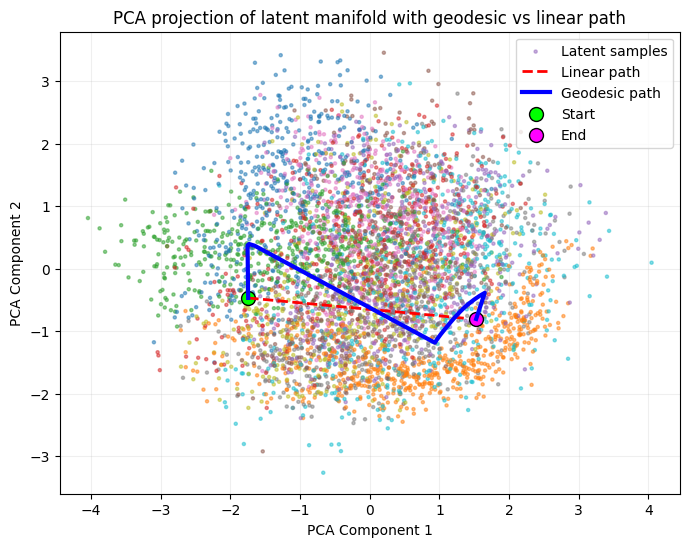

In [48]:
from sklearn.decomposition import PCA

# Collect latent samples from the dataset
vae.eval()
latents = []
labels = []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        mu, _ = vae.encode(x)
        latents.append(mu.cpu())
        labels.append(y)
latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

# Fit PCA on latent samples
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latents)

# Project both paths
geo_2d = pca.transform(geo_path.detach().cpu().numpy())
lin_2d = pca.transform(lin_path.detach().cpu().numpy())

# Plot
plt.figure(figsize=(8,6))
plt.scatter(latent_2d[:,0], latent_2d[:,1], c=labels, s=5, cmap="tab10", alpha=0.5, label="Latent samples")
plt.plot(lin_2d[:,0], lin_2d[:,1], 'r--', lw=2, label="Linear path")
plt.plot(geo_2d[:,0], geo_2d[:,1], 'b-', lw=3, label="Geodesic path")
plt.scatter(geo_2d[0,0], geo_2d[0,1], c='lime', s=100, edgecolors='k', label="Start")
plt.scatter(geo_2d[-1,0], geo_2d[-1,1], c='magenta', s=100, edgecolors='k', label="End")
plt.legend()
plt.title("PCA projection of latent manifold with geodesic vs linear path")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True, alpha=0.2)
plt.savefig("pca-projection.png")
plt.show()